In [1]:
lumpy_trans_file = '../final_calls/lumpy.calls'
genomestrip_trans_file = '../final_calls/genomestrip.calls'
breakdancer_trans_file = '../final_calls/breakdancer.calls'

In [2]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
sample_id_to_affected = dict()
sample_id_to_sex = dict()
sample_id_to_parent_ids = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                sample_id_to_affected[child_id] = disease_status
                sample_id_to_sex[child_id] = sex
                sample_id_to_parent_ids[child_id] = (f_id, m_id)

In [72]:
import json

# load iHART deletions
with open('../final_calls/filtered_test_deletions.json', 'r') as f:
    ihart_deletions = json.load(f)

In [73]:
print(ihart_deletions[0])

{'family': 'AU0012.AU001201.AU001202', 'chrom': '15', 'start_pos': 20683616, 'end_pos': 20683754, 'length': 139, 'opt_start_pos': 20683616, 'opt_end_pos': 20683754, 'opt_length': 139, 'trans': ['AU001203', 'AU001204'], 'notrans': [], 'is_mat': True, 'is_pat': False, 'mother': 'AU001201', 'father': 'AU001202'}


In [74]:
from collections import defaultdict

my_trans = defaultdict(list)
for d in ihart_deletions:
    if d['is_mat']:
        for c in d['trans']:
            trans = (d['mother'], c)
            my_trans[(trans, str(d['chrom']))].append(d)     
    if d['is_pat']:
        for c in d['trans']:
            trans = (d['father'], c)
            my_trans[(trans, str(d['chrom']))].append(d)   

In [80]:
lumpy_trans = defaultdict(list)
with open(lumpy_trans_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        chrom, start, end = pieces[:3]
        trans = pieces[9:]
        for x in trans:
            lumpy_trans[(tuple(x.split('-')), chrom)].append((chrom, int(start), int(end)))

In [81]:
genomestrip_trans = defaultdict(list)
with open(genomestrip_trans_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        chrom, start, end = pieces[:3]
        trans = pieces[9:]
        for x in trans:
            genomestrip_trans[(tuple(x.split('-')), chrom)].append((chrom, int(start), int(end)))

In [82]:
breakdancer_trans = defaultdict(list)
with open(breakdancer_trans_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        chrom, start, end = pieces[:3]
        trans = pieces[9:]
        for x in trans:
            breakdancer_trans[(tuple(x.split('-')), chrom)].append((chrom, int(start), int(end)))

In [83]:
print(len(my_trans), len(lumpy_trans), len(genomestrip_trans), len(breakdancer_trans))

35 51390 35565 51478


In [84]:
# make sure we're using same set of families
my_sample_ids = set([x[0][0] for x in my_trans.keys()] + [x[0][1] for x in my_trans.keys()])
lumpy_sample_ids = set([x[0][0] for x in lumpy_trans.keys()] + [x[0][1] for x in lumpy_trans.keys()])
genomestrip_sample_ids = set([x[0][0] for x in genomestrip_trans.keys()] + [x[0][1] for x in genomestrip_trans.keys()])
breakdancer_sample_ids = set([x[0][0] for x in breakdancer_trans.keys()] + [x[0][1] for x in breakdancer_trans.keys()])

all_sample_ids = my_sample_ids & lumpy_sample_ids & genomestrip_sample_ids & breakdancer_sample_ids
print(len(my_sample_ids), len(lumpy_sample_ids), len(genomestrip_sample_ids), len(breakdancer_sample_ids), len(all_sample_ids))

54 2231 2126 2231 54


In [85]:
my_trans = dict([(k, v) for k, v in my_trans.items() if k[0][0] in all_sample_ids and k[0][1] in all_sample_ids])
lumpy_trans = dict([(k, v) for k, v in lumpy_trans.items() if k[0][0] in all_sample_ids and k[0][1] in all_sample_ids])
genomestrip_trans = dict([(k, v) for k, v in genomestrip_trans.items() if k[0][0] in all_sample_ids and k[0][1] in all_sample_ids])
breakdancer_trans = dict([(k, v) for k, v in breakdancer_trans.items() if k[0][0] in all_sample_ids and k[0][1] in all_sample_ids])

print(len(my_trans), len(lumpy_trans), len(genomestrip_trans), len(breakdancer_trans))

35 770 825 770


In [86]:
# make sure we have same chroms
my_chroms = set([x[1] for x in my_trans.keys()])
lumpy_chroms = set([x[1] for x in lumpy_trans.keys()])
genomestrip_chroms = set([x[1] for x in genomestrip_trans.keys()])
breakdancer_chroms = set([x[1] for x in breakdancer_trans.keys()])

all_chroms = my_chroms & lumpy_chroms & genomestrip_chroms & breakdancer_chroms
print(len(my_chroms), len(lumpy_chroms), len(genomestrip_chroms), len(breakdancer_chroms), len(all_chroms))

1 22 24 22 1


In [79]:
my_trans = dict([(k, v) for k, v in my_trans.items() if k[1] in all_chroms])
lumpy_trans = dict([(k, v) for k, v in lumpy_trans.items() if k[1] in all_chroms])
genomestrip_trans = dict([(k, v) for k, v in genomestrip_trans.items() if k[1] in all_chroms])
breakdancer_trans = dict([(k, v) for k, v in breakdancer_trans.items() if k[1] in all_chroms])

print(len(my_trans), len(lumpy_trans), len(genomestrip_trans), len(breakdancer_trans))

35 38 38 38


In [65]:
lumpy_support = set()
for k, other_dels in lumpy_trans.items():
    if k in my_trans:
        my_dels = my_trans[k]
    
        for od in other_dels:
            od_start, od_end = od[1:3]
            for md in my_dels:
                md_start, md_end = md['start_pos'], md['end_pos']
                if od_end < md_start or md_end < od_start:
                    overlap = 0
                elif od_start <= md_start and od_end >= md_end:
                    overlap = md_end-md_start+1
                elif md_start <= od_start and md_end >= od_end:
                    overlap = od_end-od_start+1
                elif md_start < od_end:
                    overlap = od_end - md_start + 1
                elif od_start < md_end:
                    overlap = md_end - od_start + 1

                if overlap/(md_end-md_start+1) >= 0.5 and overlap/(od_end-od_start+1) >= 0.5:
                    lumpy_support.add((k[0][0], k[0][1], k[1], md_start, md_end))




In [66]:
genomestrip_support = set()
for k, other_dels in genomestrip_trans.items():
    if k in my_trans:
        my_dels = my_trans[k]
    
        for od in other_dels:
            od_start, od_end = od[1:3]
            for md in my_dels:
                md_start, md_end = md['start_pos'], md['end_pos']
                if od_end < md_start or md_end < od_start:
                    overlap = 0
                elif od_start <= md_start and od_end >= md_end:
                    overlap = md_end-md_start+1
                elif md_start <= od_start and md_end >= od_end:
                    overlap = od_end-od_start+1
                elif md_start < od_end:
                    overlap = od_end - md_start + 1
                elif od_start < md_end:
                    overlap = md_end - od_start + 1

                if overlap/(md_end-md_start+1) >= 0.5 and overlap/(od_end-od_start+1) >= 0.5:
                    genomestrip_support.add((k[0][0], k[0][1], k[1], md_start, md_end))

In [67]:
breakdancer_support = set()
for k, other_dels in breakdancer_trans.items():
    if k in my_trans:
        my_dels = my_trans[k]
    
        for od in other_dels:
            od_start, od_end = od[1:3]
            for md in my_dels:
                md_start, md_end = md['start_pos'], md['end_pos']
                if od_end < md_start or md_end < od_start:
                    overlap = 0
                elif od_start <= md_start and od_end >= md_end:
                    overlap = md_end-md_start+1
                elif md_start <= od_start and md_end >= od_end:
                    overlap = od_end-od_start+1
                elif md_start < od_end:
                    overlap = od_end - md_start + 1
                elif od_start < md_end:
                    overlap = md_end - od_start + 1

                if overlap/(md_end-md_start+1) >= 0.5 and overlap/(od_end-od_start+1) >= 0.5:
                    breakdancer_support.add((k[0][0], k[0][1], k[1], md_start, md_end))

In [68]:
print('I called', sum([len(v) for v in my_trans.values()]), 'transmissions')
print('Lumpy supported', len(lumpy_support))
print('Genomestrip supported', len(genomestrip_support))
print('Breakdancer supported', len(breakdancer_support))
print('All supported', len(lumpy_support & genomestrip_support & breakdancer_support))
print('At least one supported', len(lumpy_support | genomestrip_support | breakdancer_support))

print()

print('Lumpy called', sum([len(v) for v in lumpy_trans.values()]))
print('Genomestrip called', sum([len(v) for v in genomestrip_trans.values()]))
print('Breakdancer called', sum([len(v) for v in breakdancer_trans.values()]))

I called 104 transmissions
Lumpy supported 17
Genomestrip supported 8
Breakdancer supported 13
All supported 8
At least one supported 18

Lumpy called 5237
Genomestrip called 1068
Breakdancer called 1940


In [69]:
len(all_sample_ids)

57

In [70]:
print('a', len(lumpy_support - genomestrip_support - breakdancer_support))
print('b', len(genomestrip_support - lumpy_support - breakdancer_support))
print('c', len(breakdancer_support - genomestrip_support - lumpy_support))
print('ab', len((lumpy_support & genomestrip_support) - breakdancer_support))
print('ac', len((lumpy_support & breakdancer_support) - genomestrip_support))
print('bc', len((genomestrip_support & breakdancer_support) - lumpy_support))
print('abc', len(lumpy_support & genomestrip_support & breakdancer_support))

a 5
b 0
c 1
ab 0
ac 4
bc 0
abc 8


7 28


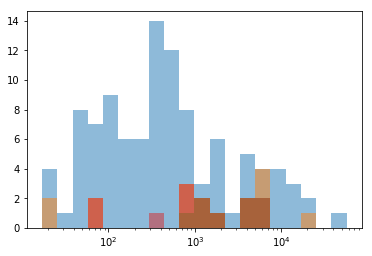

In [71]:
import matplotlib.pyplot as plt
import math

base = 1.5
lengths = [x['length'] for x in sum(my_trans.values(), [])]
min_bin = math.floor(math.log(min(lengths), base))
max_bin = math.ceil(math.log(max(lengths), base))+1
print(min_bin, max_bin)

plt.hist(lengths, 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5)
plt.hist([x[-1]-x[-2] for x in lumpy_support], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5)
plt.hist([x[-1]-x[-2] for x in genomestrip_support], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5)
plt.hist([x[-1]-x[-2] for x in breakdancer_support], 
         bins=[pow(base, i) for i in range(min_bin, max_bin)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()